In [ ]:
!pip install category_encoders==2.*
!pip install pdpbox

In [2]:
#importing needed libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


data can be downloaded from Kaggle using link https://www.kaggle.com/deepankurk/flight-take-off-data-jfk-airport?select=M1_final.csv

In [3]:
def wrangle (file_url):
  df = pd.read_csv(file_url)

  #Creating new column for year
  df.loc[df['MONTH'] < 2, 'YEAR'] = 2020 ##January (1) is year 2020
  df.loc[df['MONTH'] >= 2, 'YEAR'] = 2019 ##Nov, Dec is 2019
  
 
  #Creating new column for 'DATE' that combines year, month, and day columns then dropping year, month, day columns
  df.rename(columns={'DAY_OF_MONTH': 'DAY'}, inplace = True) #renaming the DAY OF MONTH column to easier convert to datetime format
  df['DATE'] =  pd.to_datetime(df[['YEAR','MONTH', 'DAY']])
  df.drop(columns = ['DAY', 'MONTH', 'YEAR'], inplace = True)
  
  #setting date as index
  df.set_index('DATE', inplace = True)

   #all numerical values but dtype is object, changing to int to help with onehot encoder down the line
  df['Dew Point'] = df['Dew Point'].astype(int)
  
  #dropping high cardinality columns
  cutoff = 60
  drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  #all numerical values but dtype is object, changing to int to help with onehot encoder down the line
  df['Dew Point'] = df['Dew Point'].astype(int)



  return df

df = wrangle('M1_final.csv')

df.head()


,DAY_OF_WEEK,OP_UNIQUE_CARRIER,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_M,DEP_TIME_M,CRS_ARR_M,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Condition,sch_dep,sch_arr,TAXI_OUT
DATE,,,,,,,,,,,,,,,,,,,
2019-11-01,5,B6,-1,124,636,324,323,448,48,34,58,W,25,38,29.86,Fair / Windy,9,17,14
2019-11-01,5,B6,-7,371,2475,340,333,531,48,34,58,W,25,38,29.86,Fair / Windy,9,17,15
2019-11-01,5,B6,40,181,1069,301,341,482,48,34,58,W,25,38,29.86,Fair / Windy,9,17,22
2019-11-01,5,B6,-2,168,944,345,343,513,48,34,58,W,25,38,29.86,Fair / Windy,9,17,12
2019-11-01,5,DL,-4,139,760,360,356,499,46,32,58,W,24,35,29.91,Fair / Windy,9,17,13


In [4]:
#setting TAXI_OUT column as feature (y) and X as all remaining columns
target = 'TAXI_OUT'
X = df.drop(columns = target)
y = df[target]


In [5]:
#random split into training and test data. 
##note:not using date since there is not an even way to distribute and have close to an 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .2, random_state = 42)

In [6]:
#using average values of feature column to calculate MAE and make that the baseline
y_pred = [y_train.mean()] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred)
print('Baseline MAE:', baseline_mae)

Baseline MAE: 5.493762343599579


In [7]:
#creating linear regression model and fitting training data
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names= True),  
    LinearRegression()
)
model_lr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['OP_UNIQUE_CARRIER', 'Wind', 'Condition'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [14]:
#creating ridge regression model and fitting training data
model_r = make_pipeline(
    OneHotEncoder(use_cat_names= True),  
    Ridge(alpha=.5)
)  
model_r.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['OP_UNIQUE_CARRIER', 'Wind', 'Condition'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('ridge',
                 Ridge(alpha=0.5, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [15]:
#creating GBM model and fitting training data
model_gbm = make_pipeline(
    OneHotEncoder(use_cat_names= True),  
    GradientBoostingRegressor(random_state=42)
)
model_gbm.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['OP_UNIQUE_CARRIER', 'Wind', 'Condition'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.1, loss='ls',
                                           max_depth=3, max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           m

In [16]:
#creating XGB model and fitting training data
model_xgb = make_pipeline(
    OneHotEncoder(use_cat_names= True), 
    SimpleImputer(strategy='mean'), 
    XGBRegressor(random_state=42,n_jobs=-1)
)

model_xgb.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[17:18:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['OP_UNIQUE_CARRIER', 'Wind', 'Condition'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('xgbreg...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=-1,
                              nthread=Non

In [19]:
#creating Random Forest model and fitting training data
model_rf = make_pipeline(
    OneHotEncoder(use_cat_names= True), 
    SimpleImputer(strategy='mean'), 
    RandomForestRegressor(random_state=42,n_jobs=-1)
)

model_rf.fit(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['OP_UNIQUE_CARRIER', 'Wind', 'Condition'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('random...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_

In [22]:
##calculating the MAE for both the training and test data for each model listed above

training_mae_lr = mean_absolute_error(y_train, model_lr.predict(X_train))
test_mae_lr = mean_absolute_error(y_test, model_lr.predict(X_test))

print('Linear Training MAE:', training_mae_lr)
print('Linear Test MAE:', test_mae_lr)

training_mae_r = mean_absolute_error(y_train, model_r.predict(X_train))
test_mae_r = mean_absolute_error(y_test, model_r.predict(X_test))

print('Ridge Training MAE:', training_mae_r)
print('Ridge Test MAE:', test_mae_r)

y_pred = model_xgb.predict(X_train)
y_pred_test = model_xgb.predict(X_test)

training_mae = mean_absolute_error(y_train, y_pred)
test_mae = mean_absolute_error(y_test, y_pred_test)
print('Training MAE xgb:', training_mae)
print('XGB Test MAE:', test_mae)

y_pred_gbm = model_gbm.predict(X_train)
y_pred_test_gbm = model_gbm.predict(X_test)

training_mae_gbm = mean_absolute_error(y_train, y_pred_gbm)
test_mae_gbm = mean_absolute_error(y_test, y_pred_test_gbm)
print('Training MAE gbm:', training_mae_gbm)
print('GBM Test MAE:', test_mae_gbm)

y_pred_rf = model_rf.predict(X_train)
y_pred_test_rf = model_rf.predict(X_test)

training_mae_rf = mean_absolute_error(y_train, y_pred_rf)
test_mae_rf = mean_absolute_error(y_test, y_pred_test_rf)
print('Training MAE rf:', training_mae_rf)
print('Random Forest Test MAE:', test_mae_rf)

Linear Test MAE: 5.111500582201669
Ridge Test MAE: 5.11188206301841
XGB Test MAE: 4.924900259266787
GBM Test MAE: 4.919177417701086
Random Forest Test MAE: 4.442414989590562


Text(0.5, 1.0, 'Top 10 Features')

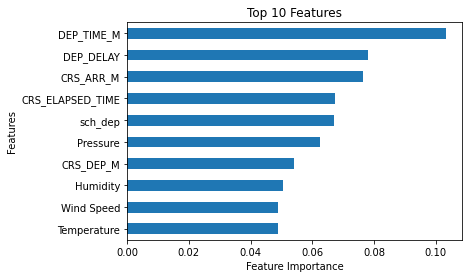

In [28]:


##creating horizontal bar chart for the top ten influencing features
features = model_rf.named_steps['onehotencoder'].get_feature_names()
importances = model_rf.named_steps['randomforestregressor'].feature_importances_
pd.Series(data=importances, index=features).sort_values(key=abs).tail(10).plot(kind='barh')
plt.ylabel('Features')
plt.xlabel('Feature Importance')
plt.title('Top 10 Features')


Text(0.5, 1.0, 'Top 10 Features')

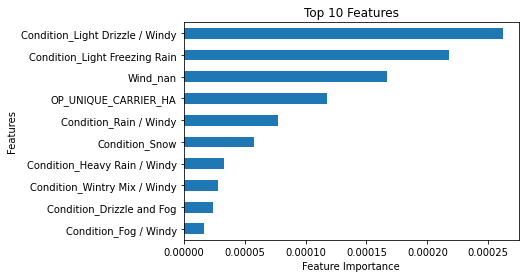

In [27]:
##creating horizontal bar chart for the bottom ten influencing features
features = model_rf.named_steps['onehotencoder'].get_feature_names()
importances = model_rf.named_steps['randomforestregressor'].feature_importances_
pd.Series(data=importances, index=features).sort_values(key=abs).head(10).plot(kind='barh')
plt.ylabel('Features')
plt.xlabel('Feature Importance')
plt.title('Top 10 Features')

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f7b62ea50d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f7b6205c350>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


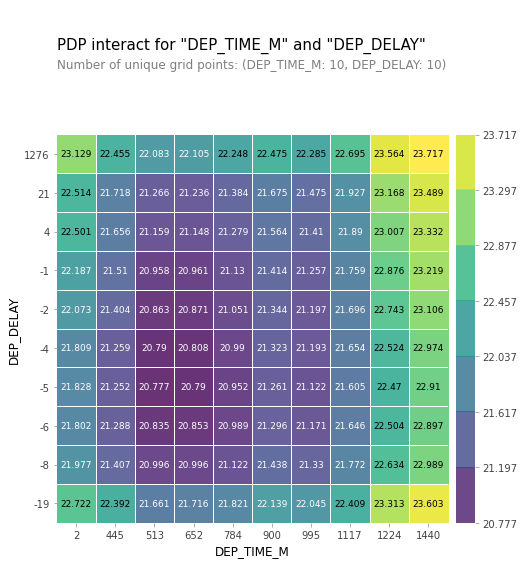

In [26]:
#creating a PDP interaction chart to compare the top two influencing features
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

features = ['DEP_TIME_M', 'DEP_DELAY']

interact = pdp_interact(model_rf,
                        dataset = X_test,
                        model_features = X_test.columns,
                        features=features)

pdp_interact_plot(interact,plot_type='grid',feature_names = features)